In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/2.3_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/2.3_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-GA':1,
              'I-FLUID':2,
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/2.3_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 68:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 68))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 2343 word vectors.


In [7]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            68,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(4, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 68)            159528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 8)             2336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 8)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 3)             27        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 3)             27        
Total params: 161,918
Trainable params: 2,390
Non-trainable params: 159,528
_________________________________________________________________


In [8]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 1612 samples, validate on 180 samples
Epoch 1/1000
1612/1612 [==============================] - 2s 1ms/step - loss: 2.2962 - crf_viterbi_accuracy: 0.4211 - val_loss: 1.6615 - val_crf_viterbi_accuracy: 0.8257
Epoch 2/1000
1612/1612 [==============================] - 1s 550us/step - loss: 1.8203 - crf_viterbi_accuracy: 0.7371 - val_loss: 1.5674 - val_crf_viterbi_accuracy: 0.8582
Epoch 3/1000
1612/1612 [==============================] - 1s 572us/step - loss: 1.7542 - crf_viterbi_accuracy: 0.7811 - val_loss: 1.5490 - val_crf_viterbi_accuracy: 0.8585
Epoch 4/1000
1612/1612 [==============================] - 1s 605us/step - loss: 1.7283 - crf_viterbi_accuracy: 0.7990 - val_loss: 1.5385 - val_crf_viterbi_accuracy: 0.8585
Epoch 5/1000
1612/1612 [==============================] - 1s 582us/step - loss: 1.7019 - crf_viterbi_accuracy: 0.8063 - val_loss: 1.5282 - val_crf_viterbi_accuracy: 0.8585
Epoch 6/1000
1612/1612 [==============================] - 1s 547us/step - loss: 1.6782 - crf_

Epoch 46/1000
1612/1612 [==============================] - 1s 574us/step - loss: 1.4783 - crf_viterbi_accuracy: 0.8597 - val_loss: 1.3690 - val_crf_viterbi_accuracy: 0.8710
Epoch 47/1000
1612/1612 [==============================] - 1s 567us/step - loss: 1.4787 - crf_viterbi_accuracy: 0.8592 - val_loss: 1.3669 - val_crf_viterbi_accuracy: 0.8710
Epoch 48/1000
1612/1612 [==============================] - 1s 569us/step - loss: 1.4768 - crf_viterbi_accuracy: 0.8583 - val_loss: 1.3646 - val_crf_viterbi_accuracy: 0.8708
Epoch 49/1000
1612/1612 [==============================] - 1s 577us/step - loss: 1.4722 - crf_viterbi_accuracy: 0.8607 - val_loss: 1.3624 - val_crf_viterbi_accuracy: 0.8718
Epoch 50/1000
1612/1612 [==============================] - 1s 577us/step - loss: 1.4696 - crf_viterbi_accuracy: 0.8607 - val_loss: 1.3607 - val_crf_viterbi_accuracy: 0.8718
Epoch 51/1000
1612/1612 [==============================] - 1s 582us/step - loss: 1.4685 - crf_viterbi_accuracy: 0.8599 - val_loss: 1.35

1612/1612 [==============================] - 1s 614us/step - loss: 1.3922 - crf_viterbi_accuracy: 0.8796 - val_loss: 1.2695 - val_crf_viterbi_accuracy: 0.8974
Epoch 141/1000
1612/1612 [==============================] - 1s 655us/step - loss: 1.3913 - crf_viterbi_accuracy: 0.8812 - val_loss: 1.2686 - val_crf_viterbi_accuracy: 0.8999
Epoch 142/1000
1612/1612 [==============================] - 1s 629us/step - loss: 1.3911 - crf_viterbi_accuracy: 0.8815 - val_loss: 1.2681 - val_crf_viterbi_accuracy: 0.8999
Epoch 143/1000
1612/1612 [==============================] - 1s 600us/step - loss: 1.3900 - crf_viterbi_accuracy: 0.8827 - val_loss: 1.2674 - val_crf_viterbi_accuracy: 0.9006
Epoch 144/1000
1612/1612 [==============================] - 1s 594us/step - loss: 1.3895 - crf_viterbi_accuracy: 0.8823 - val_loss: 1.2669 - val_crf_viterbi_accuracy: 0.9010
Epoch 145/1000
1612/1612 [==============================] - 1s 600us/step - loss: 1.3896 - crf_viterbi_accuracy: 0.8817 - val_loss: 1.2669 - val_

1612/1612 [==============================] - 1s 561us/step - loss: 1.3593 - crf_viterbi_accuracy: 0.8972 - val_loss: 1.2285 - val_crf_viterbi_accuracy: 0.9295
Epoch 235/1000
1612/1612 [==============================] - 1s 563us/step - loss: 1.3594 - crf_viterbi_accuracy: 0.8962 - val_loss: 1.2281 - val_crf_viterbi_accuracy: 0.9299
Epoch 236/1000
1612/1612 [==============================] - 1s 560us/step - loss: 1.3599 - crf_viterbi_accuracy: 0.8962 - val_loss: 1.2277 - val_crf_viterbi_accuracy: 0.9316
Epoch 237/1000
1612/1612 [==============================] - 1s 563us/step - loss: 1.3604 - crf_viterbi_accuracy: 0.8975 - val_loss: 1.2272 - val_crf_viterbi_accuracy: 0.9321
Epoch 238/1000
1612/1612 [==============================] - 1s 616us/step - loss: 1.3598 - crf_viterbi_accuracy: 0.8963 - val_loss: 1.2269 - val_crf_viterbi_accuracy: 0.9325
Epoch 239/1000
1612/1612 [==============================] - 1s 590us/step - loss: 1.3558 - crf_viterbi_accuracy: 0.8980 - val_loss: 1.2267 - val_

1612/1612 [==============================] - 1s 616us/step - loss: 1.3439 - crf_viterbi_accuracy: 0.9055 - val_loss: 1.2067 - val_crf_viterbi_accuracy: 0.9382
Epoch 329/1000
1612/1612 [==============================] - 1s 614us/step - loss: 1.3426 - crf_viterbi_accuracy: 0.9034 - val_loss: 1.2062 - val_crf_viterbi_accuracy: 0.9397
Epoch 330/1000
1612/1612 [==============================] - 1s 582us/step - loss: 1.3428 - crf_viterbi_accuracy: 0.9060 - val_loss: 1.2059 - val_crf_viterbi_accuracy: 0.9414
Epoch 331/1000
1612/1612 [==============================] - 1s 593us/step - loss: 1.3388 - crf_viterbi_accuracy: 0.9048 - val_loss: 1.2056 - val_crf_viterbi_accuracy: 0.9416
Epoch 332/1000
1612/1612 [==============================] - 1s 592us/step - loss: 1.3387 - crf_viterbi_accuracy: 0.9072 - val_loss: 1.2054 - val_crf_viterbi_accuracy: 0.9411
Epoch 333/1000
1612/1612 [==============================] - 1s 586us/step - loss: 1.3390 - crf_viterbi_accuracy: 0.9095 - val_loss: 1.2053 - val_

1612/1612 [==============================] - 1s 574us/step - loss: 1.3328 - crf_viterbi_accuracy: 0.9096 - val_loss: 1.1923 - val_crf_viterbi_accuracy: 0.9433
Epoch 423/1000
1612/1612 [==============================] - 1s 580us/step - loss: 1.3299 - crf_viterbi_accuracy: 0.9131 - val_loss: 1.1921 - val_crf_viterbi_accuracy: 0.9433
Epoch 424/1000
1612/1612 [==============================] - 1s 578us/step - loss: 1.3314 - crf_viterbi_accuracy: 0.9110 - val_loss: 1.1920 - val_crf_viterbi_accuracy: 0.9433
Epoch 425/1000
1612/1612 [==============================] - 1s 580us/step - loss: 1.3298 - crf_viterbi_accuracy: 0.9120 - val_loss: 1.1920 - val_crf_viterbi_accuracy: 0.9433
Epoch 426/1000
1612/1612 [==============================] - 1s 600us/step - loss: 1.3297 - crf_viterbi_accuracy: 0.9115 - val_loss: 1.1917 - val_crf_viterbi_accuracy: 0.9433
Epoch 427/1000
1612/1612 [==============================] - 1s 586us/step - loss: 1.3347 - crf_viterbi_accuracy: 0.9101 - val_loss: 1.1918 - val_

1612/1612 [==============================] - 1s 596us/step - loss: 1.3241 - crf_viterbi_accuracy: 0.9114 - val_loss: 1.1827 - val_crf_viterbi_accuracy: 0.9492
Epoch 517/1000
1612/1612 [==============================] - 1s 589us/step - loss: 1.3224 - crf_viterbi_accuracy: 0.9143 - val_loss: 1.1827 - val_crf_viterbi_accuracy: 0.9492
Epoch 518/1000
1612/1612 [==============================] - 1s 598us/step - loss: 1.3246 - crf_viterbi_accuracy: 0.9138 - val_loss: 1.1824 - val_crf_viterbi_accuracy: 0.9492
Epoch 519/1000
1612/1612 [==============================] - 1s 590us/step - loss: 1.3272 - crf_viterbi_accuracy: 0.9111 - val_loss: 1.1823 - val_crf_viterbi_accuracy: 0.9492
Epoch 520/1000
1612/1612 [==============================] - 1s 590us/step - loss: 1.3227 - crf_viterbi_accuracy: 0.9150 - val_loss: 1.1823 - val_crf_viterbi_accuracy: 0.9492
Epoch 521/1000
1612/1612 [==============================] - 1s 610us/step - loss: 1.3246 - crf_viterbi_accuracy: 0.9148 - val_loss: 1.1823 - val_

1612/1612 [==============================] - 1s 625us/step - loss: 1.3180 - crf_viterbi_accuracy: 0.9164 - val_loss: 1.1754 - val_crf_viterbi_accuracy: 0.9519
Epoch 611/1000
1612/1612 [==============================] - 1s 583us/step - loss: 1.3194 - crf_viterbi_accuracy: 0.9169 - val_loss: 1.1752 - val_crf_viterbi_accuracy: 0.9519
Epoch 612/1000
1612/1612 [==============================] - 1s 598us/step - loss: 1.3208 - crf_viterbi_accuracy: 0.9153 - val_loss: 1.1752 - val_crf_viterbi_accuracy: 0.9517
Epoch 613/1000
1612/1612 [==============================] - 1s 606us/step - loss: 1.3209 - crf_viterbi_accuracy: 0.9147 - val_loss: 1.1750 - val_crf_viterbi_accuracy: 0.9519
Epoch 614/1000
1612/1612 [==============================] - 1s 604us/step - loss: 1.3169 - crf_viterbi_accuracy: 0.9165 - val_loss: 1.1750 - val_crf_viterbi_accuracy: 0.9517
Epoch 615/1000
1612/1612 [==============================] - 1s 606us/step - loss: 1.3179 - crf_viterbi_accuracy: 0.9172 - val_loss: 1.1748 - val_

1612/1612 [==============================] - 1s 603us/step - loss: 1.3115 - crf_viterbi_accuracy: 0.9193 - val_loss: 1.1695 - val_crf_viterbi_accuracy: 0.9535
Epoch 705/1000
1612/1612 [==============================] - 1s 609us/step - loss: 1.3126 - crf_viterbi_accuracy: 0.9192 - val_loss: 1.1693 - val_crf_viterbi_accuracy: 0.9535
Epoch 706/1000
1612/1612 [==============================] - 1s 658us/step - loss: 1.3135 - crf_viterbi_accuracy: 0.9185 - val_loss: 1.1694 - val_crf_viterbi_accuracy: 0.9535
Epoch 707/1000
1612/1612 [==============================] - 1s 598us/step - loss: 1.3142 - crf_viterbi_accuracy: 0.9197 - val_loss: 1.1694 - val_crf_viterbi_accuracy: 0.9528
Epoch 708/1000
1612/1612 [==============================] - 1s 590us/step - loss: 1.3138 - crf_viterbi_accuracy: 0.9189 - val_loss: 1.1692 - val_crf_viterbi_accuracy: 0.9535
Epoch 709/1000
1612/1612 [==============================] - 1s 604us/step - loss: 1.3138 - crf_viterbi_accuracy: 0.9205 - val_loss: 1.1695 - val_

1612/1612 [==============================] - 1s 582us/step - loss: 1.3103 - crf_viterbi_accuracy: 0.9198 - val_loss: 1.1642 - val_crf_viterbi_accuracy: 0.9551
Epoch 799/1000
1612/1612 [==============================] - 1s 581us/step - loss: 1.3101 - crf_viterbi_accuracy: 0.9197 - val_loss: 1.1641 - val_crf_viterbi_accuracy: 0.9546
Epoch 800/1000
1612/1612 [==============================] - 1s 564us/step - loss: 1.3081 - crf_viterbi_accuracy: 0.9228 - val_loss: 1.1641 - val_crf_viterbi_accuracy: 0.9551
Epoch 801/1000
1612/1612 [==============================] - 1s 565us/step - loss: 1.3098 - crf_viterbi_accuracy: 0.9228 - val_loss: 1.1641 - val_crf_viterbi_accuracy: 0.9548
Epoch 802/1000
1612/1612 [==============================] - 1s 565us/step - loss: 1.3101 - crf_viterbi_accuracy: 0.9216 - val_loss: 1.1641 - val_crf_viterbi_accuracy: 0.9546
Epoch 803/1000
1612/1612 [==============================] - 1s 567us/step - loss: 1.3069 - crf_viterbi_accuracy: 0.9220 - val_loss: 1.1640 - val_

1612/1612 [==============================] - 1s 617us/step - loss: 1.3046 - crf_viterbi_accuracy: 0.9209 - val_loss: 1.1599 - val_crf_viterbi_accuracy: 0.9568
Epoch 893/1000
1612/1612 [==============================] - 1s 611us/step - loss: 1.3048 - crf_viterbi_accuracy: 0.9226 - val_loss: 1.1597 - val_crf_viterbi_accuracy: 0.9568
Epoch 894/1000
1612/1612 [==============================] - 1s 606us/step - loss: 1.3031 - crf_viterbi_accuracy: 0.9267 - val_loss: 1.1597 - val_crf_viterbi_accuracy: 0.9559
Epoch 895/1000
1612/1612 [==============================] - 1s 599us/step - loss: 1.3048 - crf_viterbi_accuracy: 0.9222 - val_loss: 1.1594 - val_crf_viterbi_accuracy: 0.9568
Epoch 896/1000
1612/1612 [==============================] - 1s 598us/step - loss: 1.3057 - crf_viterbi_accuracy: 0.9226 - val_loss: 1.1594 - val_crf_viterbi_accuracy: 0.9559
Epoch 897/1000
1612/1612 [==============================] - 1s 600us/step - loss: 1.3061 - crf_viterbi_accuracy: 0.9232 - val_loss: 1.1595 - val_

1612/1612 [==============================] - 1s 594us/step - loss: 1.3037 - crf_viterbi_accuracy: 0.9225 - val_loss: 1.1556 - val_crf_viterbi_accuracy: 0.9602
Epoch 987/1000
1612/1612 [==============================] - 1s 592us/step - loss: 1.3031 - crf_viterbi_accuracy: 0.9234 - val_loss: 1.1555 - val_crf_viterbi_accuracy: 0.9602
Epoch 988/1000
1612/1612 [==============================] - 1s 578us/step - loss: 1.3031 - crf_viterbi_accuracy: 0.9239 - val_loss: 1.1554 - val_crf_viterbi_accuracy: 0.9602
Epoch 989/1000
1612/1612 [==============================] - 1s 581us/step - loss: 1.3034 - crf_viterbi_accuracy: 0.9246 - val_loss: 1.1554 - val_crf_viterbi_accuracy: 0.9602
Epoch 990/1000
1612/1612 [==============================] - 1s 592us/step - loss: 1.3005 - crf_viterbi_accuracy: 0.9251 - val_loss: 1.1554 - val_crf_viterbi_accuracy: 0.9606
Epoch 991/1000
1612/1612 [==============================] - 1s 580us/step - loss: 1.2989 - crf_viterbi_accuracy: 0.9242 - val_loss: 1.1552 - val_

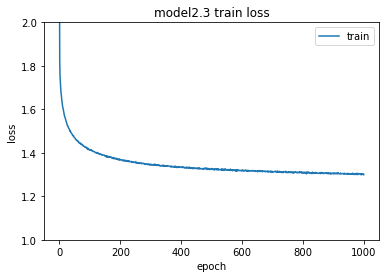

In [13]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model2.3 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([1,2])

In [16]:
model.save('/home/wcb/nerXY/model/model2.3.h5')